# Task 2

### Step one: 

A standard way to represent the noise in a quantum circuit is through Pauli operators ($\sigma_x, \sigma_y, \sigma_z$). Build a function with input $\alpha$, $\beta$ and QuantumCircuit where:

$\alpha$  → Probability of having a random Pauli operator acting on the qubit after a one-qubit gate 

$\beta$  → Probability of having a random Pauli operator acting on the qubit after a two-qubit gate 

QuantumCircuit → Quantum circuit where the noise will be added 

The output should be the Quantum Circuit with Noise 


In [1]:
import pennylane as qml
import pennylane.numpy as np
from pennylane.pauli import PauliWord, PauliSentence
from pennylane.drawer import tape_mpl
import matplotlib as plt
import pandas as pd

There is a module qml.add_noise in pennylane to simulate noise. But I preferred to write the code from scratch:

In [105]:
def noisy_QC(alpha, beta, QC):
    
    # Extract the information about the QC:
    t = QC.tape 
    ops  = t.operations
    obs  = t.observables
    mes  = t.measurements
    
    
    with qml.tape.QuantumTape() as tape_new: 
        for g in ops:      
            qml.apply(g)
            if len(g.wires) == 1: #1-qbit gate noise
                w = g.wires[0]
                paulis = ['X','Y','Z']
                choice = np.random.randint(2)
                noise =  PauliSentence({PauliWord({0:'I'}): np.sqrt((1-alpha)), 
                                        PauliWord({0:paulis[choice]}): np.sqrt(alpha) })
                U_noise = noise.to_mat()
                qml.QubitUnitary(U_noise,wires = w, id = 'Alpha')
            
        
            elif len(g.wires) == 2: #2-qbit gate noise
                w = g.wires[1]
                paulis = ['X','Y','Z']
                choice = np.random.randint(2)
                noise =  PauliSentence({PauliWord({0:'I'}): np.sqrt(1-beta), 
                                        PauliWord({0:paulis[choice]}): np.sqrt(beta) })
                U_noise = noise.to_mat()
                qml.QubitUnitary(U_noise,wires = w, id = 'Beta')
        
        [qml.apply(mes[i]) for i in range(len(mes))]
    
    return tape_new

Consdier the follwing example circuite and let's checl how adding noisy gates works:

In [102]:
dev_test = qml.device('default.qubit', wires=4)
@qml.qnode(dev_test)

def circuit(x, y):
    qml.RX(x[0], wires=0)
    qml.Toffoli(wires=(0, 1, 2))
    qml.CRY(x[0], wires=(1, 0))
    qml.Rot(x[2], x[3], y, wires=0)
    qml.PauliZ(2)
    return qml.state()

x = np.array([0.05, 0.1, 0.8, 0.3], requires_grad=True)
y = np.array(0.4, requires_grad=False)



(<Figure size 700x400 with 1 Axes>, <Axes: >)


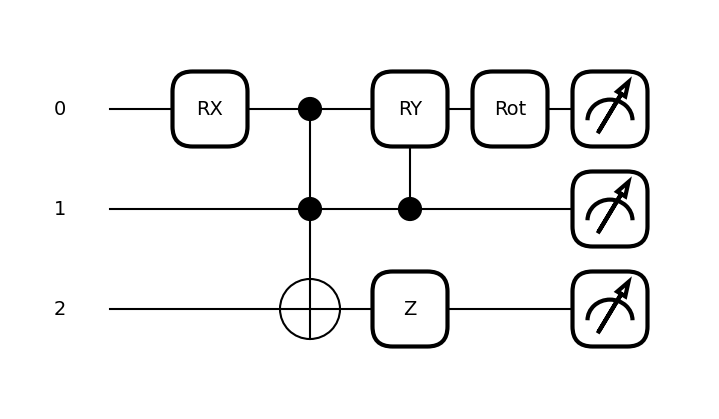

In [103]:
x = np.array([0.05, 0.1, 0.8, 0.3], requires_grad=True)
y = np.array(0.4, requires_grad=False)

print(qml.draw_mpl(circuit)(x, y))

/var/folders/94/tm2kp09x4vs6xb2y11f7qjjm0000gn/T/ipykernel_51312/115943239.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


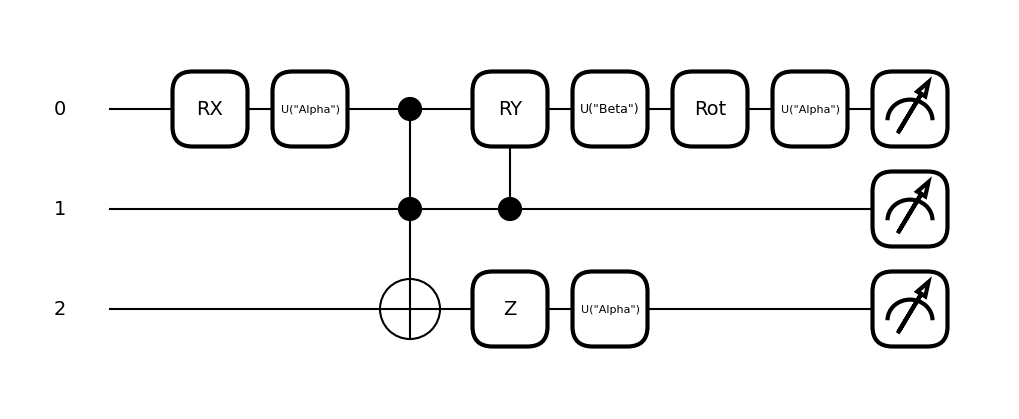

In [104]:
x = np.array([0.05, 0.1, 0.8, 0.3], requires_grad=True)
y = np.array(0.4, requires_grad=False)

test = circuit(x, y)


tape_noisy = noisy_QC(alpha = 0.7, beta = 0.12, QC = circuit)

fig, ax = tape_mpl(tape_noisy)
fig.show()



### Step Two:
Gate Basis 

Quantum computers can implement only a set of gates that, with transformations, can represent any other possible gate. This set of gates is called the Gate Basis of the QPU. Build a function that transforms a general Quantum Circuit to the following gate basis: {CX,ID,RZ,SX,X}


#### I used the buit_in module for Solovay-Kitaev decomposition. It turns out there is a bug in pennylanes module.
#### It is said that the code first decomposes the the 1-qbit gates to {H, S, SX, X, T etc} and then use Solovay-Kitaev to find an apporximation for RZ gates. However the module, for single qbits part, uses another module that doesn't work with "SX" as basis.
#### Since writing the code from scratch could take too long, I decided to use {S, H, X} basis for single qbit gates. 
#### In principle, one can replace the H-gates with SX and S. And S gates with RZ and a phase. So it wouldn't be hard to modify this ...

In [106]:
def decomposed_circuit(circ): 
    
    basis = ('I','S','H','X')
    
    return qml.transforms.clifford_t_decomposition(circ,epsilon=0.01, method = 'sk', basis_set = basis )


### Step Three
Adding two numbers with a quantum computer

Build a function (quantum_sum) to add two numbers using the Draper adder algorithm. You will need the Quantum Fourier Transform (QFT). Many libraries offer a function to use it. For this task, you will need to build QFT from scratch.


### In the following code, I first tranfored numbers into binaries, then I used PaulisWord to define the initial states.

### In the next code, I will use QuantumStateVector.

In [95]:

def quantum_sum( num_x, num_y, num_qbits = 10): #num_qubits := # of qubits
                                                #num_x and num_y the number to be added. 
                                                #only num_y will be transformed into binary series

            
    phi = 2*np.pi/(2**num_qbits)
    
    bin_y = bin(num_y)[2:]
    bin_y = '0'*(num_qbits - len(bin_y)) + bin_y
    state_y = np.array( [ int(bin_y[i]) for i in range(len(bin_y)) ] ) #This state will be fed into QFT_circuit

    dev = qml.device('default.qubit',wires=num_qbits)
    @qml.qnode(dev)

    
    def QFT_circuit (input_state, num_qbits = num_qbits): #Take the initial state as an array-like of binaries
                                                                       #This Function is not exactly as QFT
                                                                       #The final state have to be reordered.
                                                                       #Reordering is done in another function
    
        #Preparing the initial state:
        
        paulidict = {0:'I', 1: 'X'}
        initial_state = PauliWord({i: paulidict[ int(input_state[i]) ] for i in range(num_qbits) })
        if all(input_state == 0): qml.Identity
        else: 
            U_I = initial_state.to_mat()
            qml.QubitUnitary(U_I ,wires = initial_state.wires) # I used this gate to deine an initial state
                                                               # correspoinding to binary numbers.
        
        
        
         #The QFT operator:
    
        qml.Hadamard(wires = 0)
        for w in range(1,num_qbits):
            phi_w = (phi)*(input_state[w] * 2**(num_qbits - w -1))
                
            for crp in range(w):
                U = np.array([[np.exp(1j*phi_w * (2**(crp))), 0  ],
                             [0, np.exp(1j*phi_w * (2**(crp)))   ]])
                qml.ControlledQubitUnitary(U, control_wires = crp , wires = w) 
                    
            qml.Hadamard(w)
    
        return qml.state()
    
    def qft(state_vect, Inverse = False): #When Inverse is true, it computes the Inverse QFT.
        st = QFT_circuit(state_vect, num_qbits)

        def rev_bin(b): # This function is for reordering the output only.
            bin_b =  bin(b)[2:]
            bin_b = '0'*(num_qbits - len(bin_b)) + bin_b
            binary = bin_b[::-1]
            return int(binary, 2)
    
        qft0 = np.zeros(2**num_qbits, dtype=complex)
        for i in range(2**num_qbits):
            if Inverse:
                qft0[rev_bin(i)] = np.conj(st[i])
            else:
                qft0[rev_bin(i)] = st[i]
    
        return qft0
    
    
    state_qft_y = qft(state_y, Inverse = False)
    
    # The follwing state, ctrl_Z, will be given to the inverse_QFT:
    
    ctrl_Z = np.array([state_qft_y[i] *  np.exp(1j*phi * (i * num_x)) for i in range(2**num_qbits) ] )
    
    final_state = np.zeros(2**num_qbits)
    
    for num_z in range(2**num_qbits):
        
        bin_z = bin(num_z)[2:]
        bin_z = '0'*(num_qbits - len(bin_z)) + bin_z
        state_z = np.array( [ int(bin_z[i]) for i in range(len(bin_z)) ] )
        
        state_qftI_z = qft(state_z, Inverse = True)
    
        final_state = final_state + ctrl_Z[num_z] * state_qftI_z 
    
    
    return np.argmax(final_state * final_state.conj())

In [99]:
quantum_sum( num_x=15, num_y=1, num_qbits = 4)

0

In [96]:
quantum_sum( num_x=10, num_y=1, num_qbits = 4)

11

#### In the table below, you see the result of quantum addition mod 16 ( 4 qubits)

In [98]:
df = pd.DataFrame(columns = [i for i in range(16)], index = [i for i in range(16)])
for indx in range(df.shape[0]):
    for cn in range(df.shape[1]):
        df.iloc[indx,cn] = quantum_sum( num_x=indx, num_y=cn, num_qbits = 4)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,0
2,2,3,4,5,6,7,8,9,10,11,12,13,14,15,0,1
3,3,4,5,6,7,8,9,10,11,12,13,14,15,0,1,2
4,4,5,6,7,8,9,10,11,12,13,14,15,0,1,2,3
5,5,6,7,8,9,10,11,12,13,14,15,0,1,2,3,4
6,6,7,8,9,10,11,12,13,14,15,0,1,2,3,4,5
7,7,8,9,10,11,12,13,14,15,0,1,2,3,4,5,6
8,8,9,10,11,12,13,14,15,0,1,2,3,4,5,6,7
9,9,10,11,12,13,14,15,0,1,2,3,4,5,6,7,8


### Step Four

Effects of noise on quantum addition 

Now, we can combine all the functions. Transform the circuit used in the quantum_sum to the gate basis and add noise. Use different levels of noise and analyze the results. 

How does the noise affect the results? \
Is there a way to decrease the effect of noise? \
How does the number of gates used affect the results? 


In [138]:
def noisy_adder(num_x, num_y, num_qbits, alpha, beta):
    
    phi = 2*np.pi/(2**num_qbits)
    
    bin_y = bin(num_y)[2:]
    bin_y = '0'*(num_qbits - len(bin_y)) + bin_y
    state_y = np.array( [ int(bin_y[i]) for i in range(len(bin_y)) ] ) #This state will be fed into QFT_circuit

    dev = qml.device('default.qubit',wires=num_qbits)
    @qml.qnode(dev)

    
    def QFT_circuit (input_state, num_qbits = num_qbits): #Take the initial state as an array-like of binaries
                                                                       #This Function is not exactly as QFT
                                                                       #The final state have to be reordered.
                                                                       #Reordering is done in another function
    
        #Preparing the initial state:
        
        l = len(input_state)
        initial_state = np.zeros(2**l, dtype = complex)
        ind = 0
        state_y
        for i in range(l):
            ind += input_state[i]*(2** (l - i -1 ) )
        
        initial_state[int(ind)] = 1.0 + 0.0*1j
        qml.QubitStateVector(initial_state, wires=[i for i in range(num_qbits)])
        
        
        
         #The QFT operator:
    
        qml.Hadamard(wires = 0)
        for w in range(1,num_qbits):
            phi_w = (phi)*(input_state[w] * 2**(num_qbits - w -1))
                
            for crp in range(w):
                U = np.array([[np.exp(1j*phi_w * (2**(crp))), 0  ],
                             [0, np.exp(1j*phi_w * (2**(crp)))   ]])
                qml.ControlledQubitUnitary(U, control_wires = crp , wires = w) 
                    
            qml.Hadamard(w)
    
        return qml.state()
    
    ST_QFT = decomposed_circuit(QFT_circuit)
    
        
    def qft(state_vect, Inverse = False): #When Inverse is true, it computes the Inverse QFT.
        test = ST_QFT(state_vect)
        noisy_QFT = noisy_QC(alpha = alpha, beta = beta , QC = ST_QFT)
        
        st = qml.execute([noisy_QFT],dev)[0]

        def rev_bin(b): # This function is for reordering the output only.
            bin_b =  bin(b)[2:]
            bin_b = '0'*(num_qbits - len(bin_b)) + bin_b
            binary = bin_b[::-1]
            return int(binary, 2)
    
        qft0 = np.zeros(2**num_qbits, dtype=complex)
        for i in range(2**num_qbits):
            if Inverse:
                qft0[rev_bin(i)] = np.conj(st[i])
            else:
                qft0[rev_bin(i)] = st[i]
    
        return qft0
    
    
    state_qft_y = qft(state_y, Inverse = False)
    
    # The follwing state, ctrl_Z, will be given to the inverse_QFT:
    
    ctrl_Z = np.array([state_qft_y[i] *  np.exp(1j*phi * (i * num_x)) for i in range(2**num_qbits) ] )
    
    final_state = np.zeros(2**num_qbits)
    
    for num_z in range(2**num_qbits):
        
        bin_z = bin(num_z)[2:]
        bin_z = '0'*(num_qbits - len(bin_z)) + bin_z
        state_z = np.array( [ int(bin_z[i]) for i in range(len(bin_z)) ] )
        
        state_qftI_z = qft(state_z, Inverse = True)
    
        final_state = final_state + ctrl_Z[num_z] * state_qftI_z 
    
    res = np.argmax(final_state * final_state.conj())
    
    tape = ST_QFT.tape
    num_gates = len(tape.operations)
    return res, num_gates

In [139]:
noisy_adder(num_x=2, num_y=4, num_qbits=3, alpha=0.001, beta=0.001)

(6, 7)

In [142]:
alpha_effect = []
for i in range(10):
    res = noisy_adder(num_x=2, num_y=4, num_qbits=3, alpha=0.00 + 0.05*i, beta=0.001)[0]
    alpha_effect.append(res)
alpha_effect

[6, 6, 6, 6, 6, 3, 6, 7, 5, 2]

In [143]:
beta_effect = []
for i in range(10):
    res = noisy_adder(num_x=2, num_y=4, num_qbits=3, alpha=0.001, beta=0.00+0.05*i)
    beta_effect.append(res)
beta_effect

[(6, 7),
 (6, 7),
 (6, 7),
 (0, 7),
 (1, 7),
 (1, 7),
 (1, 7),
 (0, 7),
 (1, 7),
 (5, 7)]

In [149]:
beta_effect_r = [beta_effect[i][0] for i in range(10)]

Text(0.5, 1.0, 'The effect of noise on Quantum_sum(2+4)')

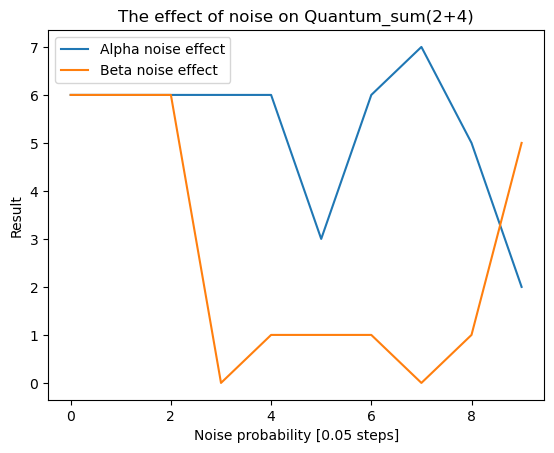

In [150]:
import matplotlib.pyplot as plt

#plt.figure(figsize = (17,5))

#plt.subplot(131)
plt.plot(range(10), alpha_effect, label = 'Alpha noise effect')
plt.plot(range(10),beta_effect_r, label = 'Beta noise effect')
plt.legend()
plt.xlabel('Noise probability [0.05 steps]')
plt.ylabel('Result')
plt.title('The effect of noise on Quantum_sum(2+4) accuracy (3 Qbits)')

plt.show()

### The effect of noises on the accuracy of the quantum ciruit is shown on this graph

The follwoign part is too slow on my computer. I had to interrupt the kernel after a while. But it generated enough data:

In [154]:
import time

gate_effect = []
gate_time = []
for i in range(6):
    start = time.time()
    res = noisy_adder(num_x=2, num_y=1, num_qbits=2+i, alpha=0.001, beta=0.001)
    end = time.time()
    gate_time.append(end-start)
    beta_effect.append(res)
gate_effect
gate_time

KeyboardInterrupt: 

In [156]:
gate_time

[0.1660780906677246, 30.714667081832886, 173.51804995536804, 841.124685049057]

In [158]:
gate_effect = beta_effect[-4:]
gate_effect

[(3, 4), (3, 7), (3, 11), (3, 16)]

Text(0.5, 0, 'Number of Qbits')

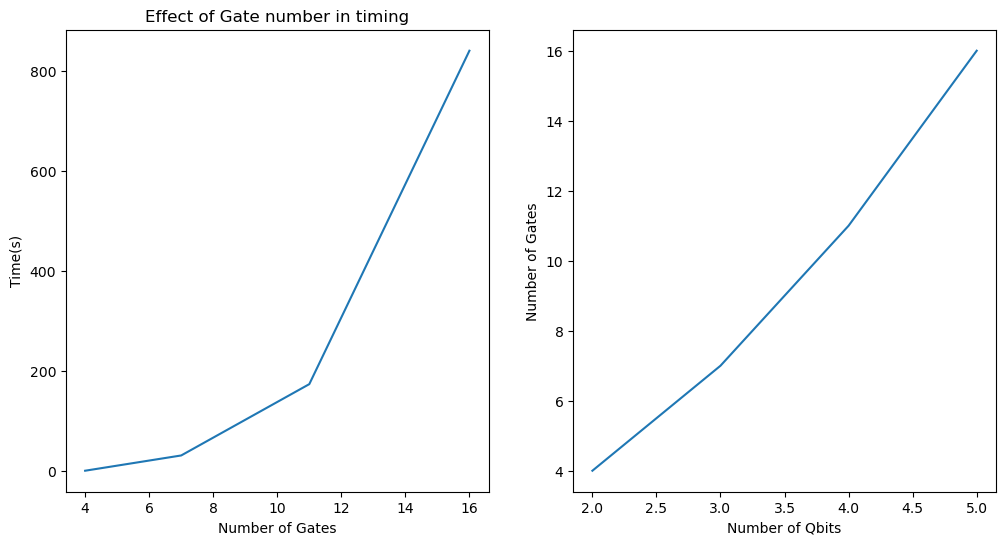

In [161]:
plt.figure(figsize = (12,6))


plt.subplot(121)
plt.plot( [gate_effect[i][1] for i in range(4)], gate_time )
plt.xlabel('Number of Gates')
plt.ylabel('Time(s)')
plt.title('Effect of Gate number in timing')

plt.subplot(122)
plt.plot(range(2,6), [gate_effect[i][1] for i in range(4)] )
plt.ylabel('Number of Gates')
plt.xlabel('Number of Qbits')




### These graphs shows time needed to complete the computaion grows exponentially in term of number of gates. 
### The growth in number of gates is almost linear relative to the number of Qbits

#### The noise caused by Z corresponds to phase flip and the noise caused by X is the bir flip error. Y is combination of both.
#### It is possible generally to use error correction codes to reduce the effect of these errors